Create table for A/A tests

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import json

In [2]:
app_bench_result_path = '../../resultsVM/regressionApp'

load data and analyze differences between runs

In [3]:
latenciesTypes = ['latenciesInserts1Old', 'latenciesInserts1New',
                  'latenciesInserts2Old', 'latenciesInserts2New',
                  'latenciesQueries1Old', 'latenciesQueries1New',
                  'latenciesQueries2Old', 'latenciesQueries2New']


In [4]:
def loadLatencies(resultPath):
    latenciesDict = {}
    for latenciesType in latenciesTypes:
        # advisable to use os.path.join as this makes concatenation OS independent
        all_files = glob.glob(os.path.join(
            resultPath, "*", latenciesType + ".csv"))

        df_from_each_file = [pd.read_csv(f, delim_whitespace=True, index_col=0, names=[
                                         int(f.split('/')[-2])]) for f in all_files]
        df_from_each_file = df_from_each_file[::-1]
        df = pd.concat(df_from_each_file, axis=1, copy=True)

        df = df.sort_index(axis=1)
        latenciesDict[latenciesType] = df
    latenciesDict = preprocess_latencies(latenciesDict)

    return latenciesDict


def preprocess_latencies(latenciesDict):
    #Read latency file for both types (old and new)
    insertsOld1 = latenciesDict['latenciesInserts1Old']
    insertsOld2 = latenciesDict['latenciesInserts2Old']
    insertsOld = pd.concat([drop_rows(insertsOld1), drop_rows(insertsOld2)])
    latenciesDict['latenciesInsertsOld'] = insertsOld

    insertsNew1 =  latenciesDict['latenciesInserts1New']
    insertsNew2 = latenciesDict['latenciesInserts2New']
    insertsNew = pd.concat([drop_rows(insertsNew1), drop_rows(insertsNew2)])
    latenciesDict['latenciesInsertsNew'] = insertsNew


    queries1Old = latenciesDict['latenciesQueries1Old']

    queries1Old = drop_rows(queries1Old)
    

    queries2Old = latenciesDict['latenciesQueries2Old']


    queries2Old = drop_rows(queries2Old)

    queries1New = latenciesDict['latenciesQueries1New']
    
    queries1New = drop_rows(queries1New)


    queries2New = latenciesDict['latenciesQueries2New']

    queries2New = drop_rows(queries2New)

    # #Find median latency for both types
    # medianInsertsOld = insertsOld["latency (ms)"].median()
    # medianInsertsNew = insertsNew["latency (ms)"].median()

    # medianQueries1Old = queries1Old["latency (ms)"].median()
    # medianQueries1New = queries1New["latency (ms)"].median()

    # medianQueries2Old = queries2Old["latency (ms)"].median()
    # medianQueries2New = queries2New["latency (ms)"].median()

    # #Calculate diff
    # diffInserts = ((medianInsertsNew / medianInsertsOld) - 1) * 100
    # diffQueries1 = ((medianQueries1New / medianQueries1Old) - 1) * 100
    # diffQueries2 = ((medianQueries2New / medianQueries2Old) - 1) * 100

    return latenciesDict

def drop_rows(df: pd.DataFrame)->pd.DataFrame:
    num_to_drop_head = int(df.shape[0] * 0.05)
    num_to_drop_tail = int(df.shape[0] * 0.2)
    df = df.drop(df.tail(num_to_drop_tail).index)
    df = df.drop(df.head(num_to_drop_head).index)
    return df



In [5]:
def relativeLatency(med1, med2): return ((med2/med1)-1)*100


def printMeanRelativeLatencies(latencies):
    med1 = latencies['latenciesInsertsOld'].median(axis=0)
    med2 = latencies['latenciesInsertsNew'].median(axis=0)

    med3 = latencies['latenciesQueries1Old'].median(axis=0)
    med4 = latencies['latenciesQueries1New'].median(axis=0)

    med5 = latencies['latenciesQueries2Old'].median(axis=0)
    med6 = latencies['latenciesQueries2New'].median(axis=0)
    print('Mean differencies:')
    print(relativeLatency(med1, med2).abs().mean(), "%")
    print(relativeLatency(med3, med4).abs().mean(), "%")
    print(relativeLatency(med5, med6).abs().mean(), "%")


In [6]:
def plotRelativeLatencies(latencies):
    med1=latencies['latenciesInsertsOld'].median(axis=0)
    med2=latencies['latenciesInsertsNew'].median(axis=0)

    med3=latencies['latenciesQueries1Old'].median(axis=0)
    med4=latencies['latenciesQueries1New'].median(axis=0)

    med5=latencies['latenciesQueries2Old'].median(axis=0)
    med6=latencies['latenciesQueries2New'].median(axis=0)
    
    

    fig, axs = plt.subplots(1, 3, figsize = (15,4), sharey=True)
    plt.suptitle('Relative differences between A1 and A2')
    
    axs[0].plot(relativeLatency(med1,med2), marker='o')
    axs[0].set_title('Inserts, latencies')
    
    axs[1].plot(relativeLatency(med3,med4),marker='o')
    axs[1].set_title('First set of queries')
    
    
    axs[2].plot(relativeLatency(med5,med6),marker='o')
    axs[2].set_title('Second set of queries')
    
    for ax in axs:
        ax.axhline(0, color='black',linestyle="--")
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.set_xlabel('commit, number')
        ax.set_ylabel('relative latency, %')
    
    printMeanRelativeLatencies(latencies)

def getRelativeLatencies(latencies):
    relative_latencies = {}
    med1=latencies['latenciesInsertsOld'].median(axis=0)
    med2=latencies['latenciesInsertsNew'].median(axis=0)

    med3=latencies['latenciesQueries1Old'].median(axis=0)
    med4=latencies['latenciesQueries1New'].median(axis=0)

    med5=latencies['latenciesQueries2Old'].median(axis=0)
    med6=latencies['latenciesQueries2New'].median(axis=0)
    
    
    relative_latencies['latenciesInserts'] = relativeLatency(med1,med2)
    relative_latencies['latenciesQueries1'] = relativeLatency(med3,med4)
    relative_latencies['latenciesQueries2'] = relativeLatency(med5,med6)
    
    return relative_latencies

def plotBoxes(relative_latencies):
    
    
    

    fig, axs = plt.subplots(1, 3, figsize = (15,4))
    
    axs[0].boxplot(relative_latencies['latenciesInserts'])
    axs[0].set_xticklabels(['Inserts'])
    
    axs[1].boxplot(relative_latencies['latenciesQueries1'])
    axs[1].set_xticklabels(['Query Set 1'])
    
    
    axs[2].boxplot(relative_latencies['latenciesQueries2'])
    axs[2].set_xticklabels(['Query Set 2'])
    
    for ax in axs:
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.set_ylabel('relative speedup, %')


In [7]:
def plotDistribution(df1, df2):
    # drop first 15% and last 30%
    # num_to_drop_head = int(np.floor(df1.shape[0] * 0.15))
    # num_to_drop_tail = int(np.floor(df1.shape[0] * 0.3))
    # df1=df1.drop(df1.tail(num_to_drop_tail).index) 
    # df1=df1.drop(df1.head(num_to_drop_head).index) 

    
    
    # num_to_drop_head = int(np.floor(df2.shape[0] * 0.15))
    # num_to_drop_tail = int(np.floor(df2.shape[0] * 0.3))
    # df2=df2.drop(df2.tail(num_to_drop_tail).index)
    # df2=df2.drop(df2.head(num_to_drop_head).index) 

     
    
    
    fig, axs = plt.subplots(10, 2, figsize = (15, 30), sharey=True)
    plt.suptitle('Relative differences between A1 and A2')
    for counter, column in enumerate(df1.columns):
        # filter outlier with 90%-quantile
        q1 = np.min(df1[column])
        q3_old = np.percentile(df1[column],90)
        q3_new = np.percentile(df2[column],90)
        q3 = np.max([q3_old, q3_new])
        
        axs[counter, 0].hist(df1[column],range=(q1, q3), density=True, bins=50)
        axs[counter, 0].set_title('commit number ' + str(column))
        
        
        axs[counter, 1].hist(df2[column], range=(q1, q3), density=True, bins=50)
        axs[counter, 1].set_title('commit number ' + str(column))

def plotRegressions(aggregation: dict):
    
    fig, axs = plt.subplots(1, 3, figsize = (15,4), sharey=True)
    plt.suptitle('Relative differences between A1 and A2')
    
    for counter, key in enumerate(['latenciesInserts', 'latenciesQueries1', 'latenciesQueries2']):
        axs[counter].plot(aggregation[key]['min'], 'b-')
        axs[counter].plot(aggregation[key]['max'], 'b-')
        axs[counter].plot(aggregation[key]['med'], 'r-')
        axs[counter].axhline(0, color='black',linestyle="--")
        axs[counter].yaxis.set_tick_params(labelbottom=True)
        axs[counter].set_xlabel('commit, number')
        axs[counter].set_ylabel('relative speedup, %')

    

def aggregate_latencies(runs: list) -> dict:
    aggregation = {}

    aggregate_on_key(runs, 'latenciesInserts', aggregation)
    aggregate_on_key(runs, 'latenciesQueries1', aggregation)
    aggregate_on_key(runs, 'latenciesQueries2', aggregation)
    
    return aggregation


    

def aggregate_on_key(runs: list, key: str, aggregation: dict) -> dict:
    data = []
    for run in runs:
        med1 = run[key + 'Old'].median()
        med2 = run[key + 'New'].median()
        data.append(relativeLatency(med1, med2))
    data = np.array(data)
    aggregation[key] = {}
    aggregation[key]['max'] = data.max(axis=0)
    aggregation[key]['min'] = data.min(axis=0)
    aggregation[key]['med'] = np.median(data, axis=0)

    return aggregation

    
        

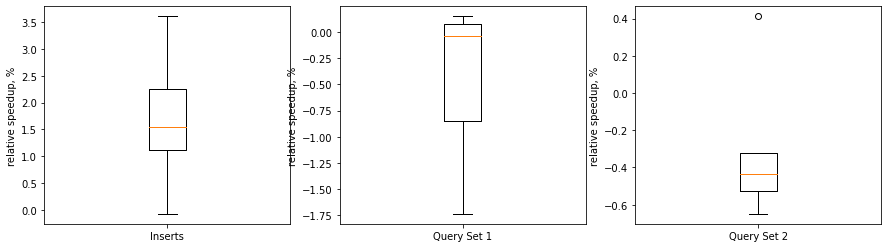

In [8]:
latencies=loadLatencies(os.path.join(app_bench_result_path, "runAA"))
relative_latencies = getRelativeLatencies(latencies)
plotBoxes(relative_latencies)
None

## Test Run for 5 random commits

Mean differencies:
1.507554050877764 %
4.905830571125532 %
2.9913444445253594 %


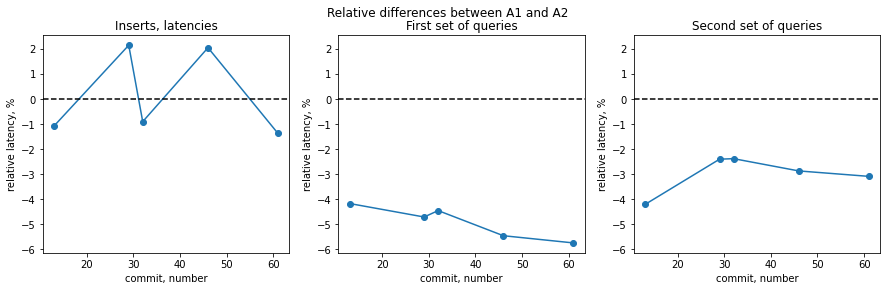

In [9]:
latencies=loadLatencies(os.path.join(app_bench_result_path, "runtest1"))
plotRelativeLatencies(latencies)

Mean differencies:
0.8862622088865457 %
5.071114825282324 %
2.6322179271991786 %


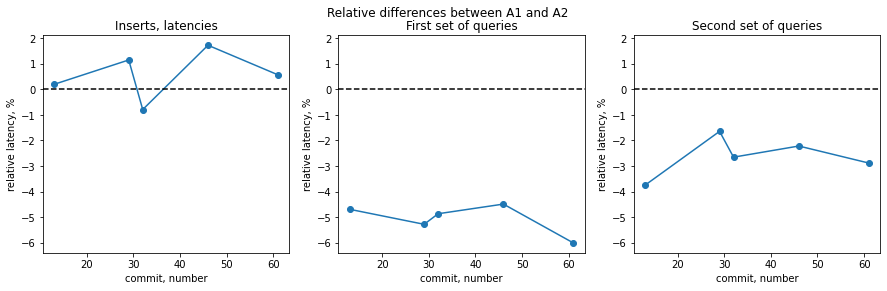

In [10]:
latencies=loadLatencies(os.path.join(app_bench_result_path, "runtest2"))
plotRelativeLatencies(latencies)

## Main Run 1

Mean differencies:
0.8862622088865457 %
5.071114825282324 %
2.6322179271991786 %


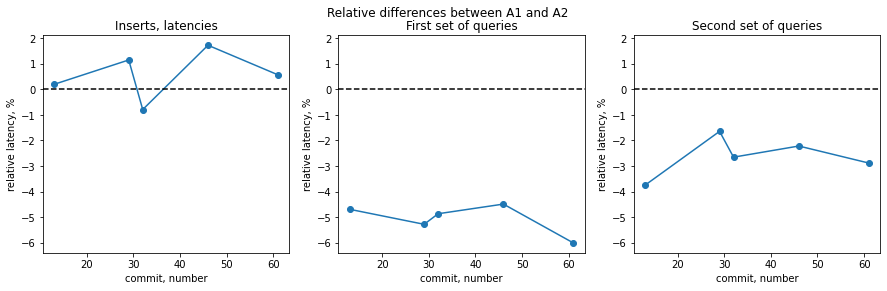

In [11]:
run1 = loadLatencies(os.path.join(app_bench_result_path, "run1"))
plotRelativeLatencies(latencies)

Mean differencies:
0.8862622088865457 %
5.071114825282324 %
2.6322179271991786 %


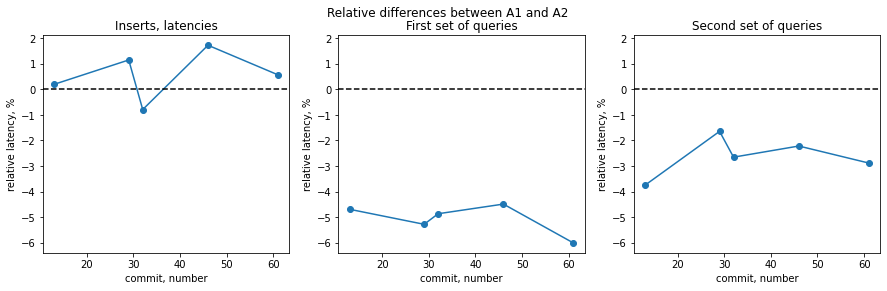

In [12]:
run2 = loadLatencies(os.path.join(app_bench_result_path, "run2"))
plotRelativeLatencies(latencies)

Mean differencies:
0.8862622088865457 %
5.071114825282324 %
2.6322179271991786 %


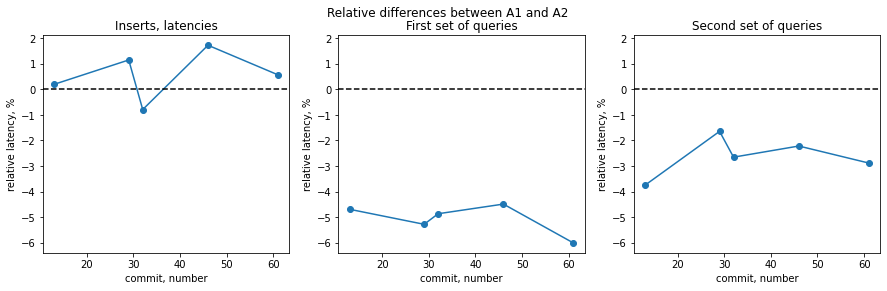

In [13]:
run3 = loadLatencies(os.path.join(app_bench_result_path, "run3"))
plotRelativeLatencies(latencies)

In [14]:
aggregation = aggregate_latencies([run1, run2, run3])

In [15]:
aggregation['latenciesInserts']['min'].shape

(69,)

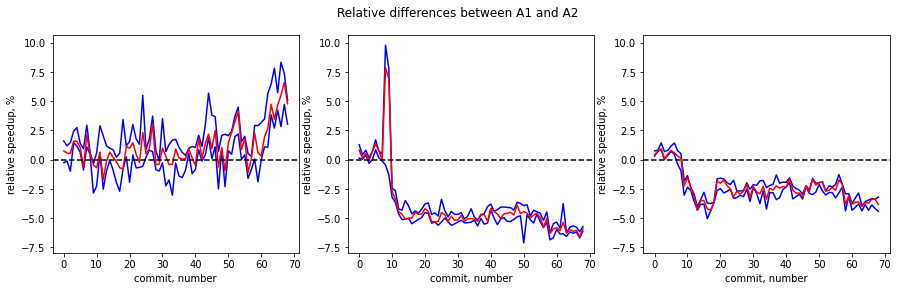

In [16]:
plotRegressions(aggregation)